## Regression Problem
#### Dataset Description:  
The dataset includes 9358 data samples of responses from 5 metal oxide chemical sensors embedded in an Air Quality Monitoring Device, recorded along with hours. The device was located on the field in a significantly polluted area in Italy. The data was collected to estimate benzene concentration with the response from the previously mentioned sensors, which are originally designed to monitor non-benzene substance concentration(i.e. there maybe a potential relationship between the concentration of benzene and the 5 kinds of non-benzene substance.).Consequently, the labels should be the true values of benzene concentration.  
The dataset is provided in S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia, On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario, Sensors and Actuators B: Chemical, Volume 129, Issue 2, 22 February 2008, Pages 750-757, ISSN 0925-4005.  

### LS Solution Approach by Changlin Jiang
#### Libraries and dataset importing

In [62]:
# import libraries
import csv
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
import copy

In [2]:
# read dataset from csv file
with open('AirQualityUCI.csv') as csv_file:
    csv_reader=csv.reader(csv_file, delimiter=',')
    date,time,CO_true,CO_measured,NMHC_true,C6H6_true,NMHC_measured,NOx_true,NOx_measured,NO2_true,NO2_measured,O3_measured,temp,RH,AH=[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)]
    #print(len(CO_true))
    line_count=0
    for row in csv_reader:
        #print(len(row))
        if row[0]=="":
            break;
        if(line_count!=0):
            date[line_count-1],time[line_count-1],CO_true[line_count-1],CO_measured[line_count-1],NMHC_true[line_count-1],C6H6_true[line_count-1],NMHC_measured[line_count-1],NOx_true[line_count-1],NOx_measured[line_count-1],NO2_true[line_count-1],NO2_measured[line_count-1],O3_measured[line_count-1],temp[line_count-1],RH[line_count-1],AH[line_count-1]=row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14]
        line_count+=1

In [3]:
print(line_count)

9358


#### Data Cleaning
The missing values in the dataset was tagged with -200. To clean the dataset, the missing values are filled with the mean of the dimension.

In [4]:
# clean the data and label by replacing invalid value with mean
def clean_replace(data,labels):
    # clean the data
    m,n=np.shape(data)
    mean=[0 for i in range(m)]
    for i in range(m):
        sum=0
        count=0
        for j in range(n):
            if(data[i,j]>=0):
                sum+=data[i,j]
                count+=1
        mean[i]=sum/count
    for i in range(m):
        for j in range(n):
            if data[i,j]<0:
                data[i,j]=mean[i]

    # clean the label
    labels=np.array(labels).astype(np.float64)
    sum=0
    count=0
    for i in range(n):
        if labels[i]>=0:
            sum+=labels[i]
            count+=1
    mean=sum/count
    for i in range(n):
        if labels[i]<0:
            labels[i]=mean
    return data,labels

#### LS solution implementation

In [5]:
# implement LS solution
def ls_solution(data,labels):
    m,n=np.shape(data)
    data_hat=np.row_stack((data,[1 for i in range(n)])).T.astype(np.float64)
    w=la.inv(data_hat.T*data_hat)*data_hat.T*labels.T
    return w

#### Cross Validation Implementation

In [42]:
# Build cross validation function, return regression error for each test and derived labels
def cross_validation(data,labels,k:int):
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    
    for i in range(k):
        test_data=fold[i].astype(np.float64)
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        w=ls_solution(training_data[:m,:],training_data[m,:])
        test_data_hat=np.row_stack((test_data[:m,:],np.mat([1 for x in range(ni)])))
        y=test_data_hat.T*w
        print(type(y))
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
        else:
            labels_derived[i*a:]=y
        reg_error[i]=la.norm(y-labels,2)
    overall_error=la.norm(reg_error)
    return reg_error,labels_derived,overall_error

In [45]:
cross_validation(data, labels, 5)

<class 'numpy.matrixlib.defmatrix.matrix'>


TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

#### Overall process implementation
The pipeline implemented is as below:  
- Data importing:  
Import data from csv file and save each dimension into a individual list.
- Data cleaning:
Fill all the missing values in data with the mean of the dimension.
- Algorithm implement:
Implement LS solution to learn the dataset.
- Algorithm evaluation:
Build K-folds cross validation to compute the regression error of the algorithm
- Parameter determination:
Run K-folds cross validation with K in a linear array to find the best K for this certain dataset.

In [7]:
# Define overall process function to show the results
def ls_regression(data,labels):
    m,n=np.shape(np.mat(data))
    if m>1:
        data=np.row_stack(data)
    data=np.mat(data).astype(np.float64)
    data,labels=clean_replace(data,labels)
    # Implement LS regression nand cross validation to find the best K
    k=[2,3,4,5,6,7,8,9,10]
    overall_error=[0 for i in range(9)]
    for i in range(9):
        overall_error[i]=cross_validation(data,labels,k[i])[2]
    # Plot the K-Error plot to show the best K
    plt.figure(1)
    plt.plot(k,overall_error)
    plt.title('K-Error Plot')
    print("The best K is ",k[overall_error.index(min(overall_error))])
    # Plot the regression result derived by the best K in a predicted-versus-measured scatter plot
    reg_error,labels_derived,overall_error=cross_validation(data,labels,k[overall_error.index(min(overall_error))])
    labels_derived=np.array(labels_derived).reshape(-1,1)
    labels=np.array(labels).reshape(1,-1).T
    plt.figure(2)
    plt.scatter(labels,labels_derived,color='b')
    ymax=max([max(labels),max(labels_derived)])
    plt.plot([0,max(labels)],[0,max(labels)], color='r', linewidth=1, alpha=0.6)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Measured Labels')
    plt.title('Overall L2-Loss Regression Error={}'.format(overall_error))

In [44]:
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=C6H6_true
ls_regression(data,labels)

<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


KeyboardInterrupt: 

In [9]:
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
targets = C6H6_true
#print(targets)

In [10]:
print(len(data))

8


In [67]:
# Build cross validation function, return regression error for each test and derived labels
def cross_validation(data,labels,k:int,alpha):
    
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    #print(data_with_labels.shape)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    w_arr = []
    for i in range(k):
        test_data=fold[i].astype(np.float64)
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        reg = linear_model.LassoLars(alpha = alpha)
        reg.fit(np.vstack((training_data[:m, :], np.ones((1, training_data.shape[1])))).T, training_data[m].T)
        w = reg.coef_[np.newaxis].T
        
        test_data_hat=np.row_stack((test_data[:m,:],np.mat([1 for x in range(ni)])))
        #print(w.shape)
        y=test_data_hat.T.dot(w)
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
            reg_error[i]=la.norm(y-np.asarray(labels)[i*a:(i+1)*a].astype(np.float64),2)
        else:
            labels_derived[i*a:]=y
            reg_error[i]=la.norm(y-np.asarray(labels)[i*a:].astype(np.float64),2)
        w_arr.append(w.T.tolist()[0])
    print('progressing')
    w_arr = np.asarray(w_arr)
    w_arr_avg = np.sum(w_arr, axis = 0)
    overall_error=la.norm(reg_error)
    return reg_error,labels_derived,overall_error, w_arr_avg
"""reg = linear_model.LassoLars(alpha=.1)
data_array = np.asarray(data).T
print(targets)
reg.fit(data_array, targets)
print(reg.coef_)"""




lasso_err, targets_est, overall_error, weights = cross_validation(data, targets, 5, 0.1)

lasso_err_arr = []
error_arr = []
weights_arr = []
for a in np.linspace(0, 0.5, num=10):
    lasso_err, targets_est, overall_error, weights = cross_validation(data, targets, 5, a)
    lasso_err_arr.append(lasso_err)
    error_arr.append(overall_error)
    weights_arr.append(weights)

    


(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing
(9, 9357)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
progressing


O:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


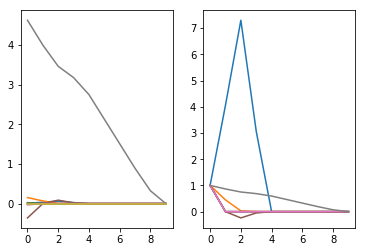

In [76]:
fig = plt.figure()
ax = fig.add_subplot(121)
#weights_list = copy.deepcopy(weights_arr)
weights_arr = np.asarray(weights_list).T
ax.plot(range(weights_arr.shape[0]), weights_arr)
ax = fig.add_subplot(122)
weights_arr = weights_arr/weights_arr[0]
ax.plot(range(weights_arr.shape[0]), weights_arr)
plt.show()

In [75]:
weights_list = weights_list.tolist()

#### Discussion:
At the start of coding this algorithm, there was a great issue. The dataset was provided by UCI, which didn't tag the labels dimension in all the 14 dimensions. Picking the right attribute took a long period of time. The process was as below.  
Firstly, I assumed UCI just provided this dataset for free-researching, i.e. there was no explicit attribute in all the attributes so that we could pick any one by our requirement to check our algorithm freely.  
Our first pick was picking the true value of CO as the labels attribute and estimate it with the responses from the 5 sensors.Firstly I directly plotted a true-versus-measured plot of CO concentration to find out if it fitted linear model.

In [ ]:
plt.scatter(CO_true,CO_measured)
plt.title('CO_True VS CO_Measured')

It can be indicated from the plot that the model is totally non-linear.The response of the sensor is likely to be random when the true concentration of CO is exactly at some certain value, plotted as vertical straight-line-like shapes in the scatter plot.  
That was the reason why I decided to treat the problem as random model, and directly implement LS solution to find out one answer:
Is there any potential relationships between the responses from the 5 sensors so that I can input all of them to get a better result on when measuring concentration of one certain kind of the substance? That is to say,if I input all the 5 measured attribute into regression algorithm, can I get a lower regression error to the true CO concentration than only inputting the measured CO concentration?  
To find out the answer, firstly I put only the measured CO concentration into LS regression algorithm to get the error:

In [ ]:
ls_regression(CO_measured,CO_true)

Then I implemented the algorithm with input dataset of all the 5 sensors responses, the result was:

In [ ]:
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=CO_true
ls_regression(data,labels)

It can be indicated by comparing the two L2-Loss that there is no enhancement by adding more attributes to the input.It seems hard to continue using the same attribute as labels.  
Finally I directly read the paper cited on the UCL dataset page and found out that the purpose of the collection of this dataset was to estimate the potential of true benzene concentration and the responses of sensors. By implementing the same algorithm on such data and labels input I got the above result.The result is the cell above this discussion section.